In [1]:
%matplotlib inline

In [2]:
import numpy as np
import csv
import matplotlib
from  matplotlib import pyplot as plt
import pandas as pd
from matplotlib.collections import LineCollection

In [4]:
df = pd.read_csv("data.csv")

In [5]:
df.head(5)

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [3]:
##normalize the data
#https://gist.github.com/perrygeo/4512375
def scale_linear_bycolumn(rawpoints, high=1.0, low=0.0):
    mins = np.min(rawpoints, axis=0)
    maxs = np.max(rawpoints, axis=0)
    rng = maxs - mins
    return high - (((high - low) * (maxs - rawpoints)) / rng)

In [6]:
df['eruptions'] = scale_linear_bycolumn(df['eruptions'])
df['waiting'] = scale_linear_bycolumn(df['waiting'])

# A )

If you set all covariance matrices to σ2I (i.e., spherical) and drive σ2 to 0, this produces hard assignments. Therefore, when we run K-means,g it’s as if we’re doing GMM with EM but instead of letting each cluster have its own covariance matrix, they all have to be round covariance matrices and we make σ2 tiny so there’s no longer any notion of shared membership between clusters. As a side note, K-means is sometimes used to initialize GMM/EM fitting

In [7]:
X = df.as_matrix()

In [8]:
df.head(5)

,eruptions,waiting
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453


# B)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


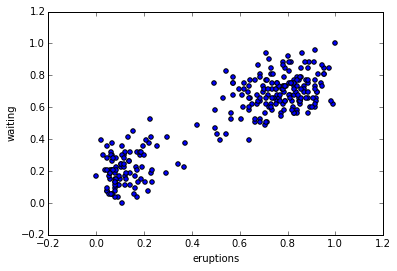

In [9]:
# pd.df.plot.scatter( x='eruptions', y='waiting')
df.plot(kind='scatter', x='eruptions', y='waiting')

# C)

In [25]:
from scipy.stats import multivariate_normal

def GMM (X, df, k=2,  mu1=None, cov1=None, mu2=None, cov2=None, pi_cons=None):
    df = df[['eruptions', 'waiting']]
    # get N, the number of rows, and d, the number of features/ columns
    N,d = X.shape

    centers = X[np.random.choice(range(X.shape[0]), k, replace=False) , : ]
    if mu1 is None: mu1 = centers[0]
    if mu2 is None: mu2 = centers[1]

    ##initialize the covariance matrices as some factor * the identity matrix of size 2 * 2
    if cov1 is None: cov1 = np.random.random() * np.eye(2)
    if cov2 is None: cov2 = np.random.random() * np.eye(2)

    ## Initialize our pi constant to a random number 
    if pi_cons is None: pi_cons = np.random.random()

#     print ("initial mu1, mu2: ", mu1, ", " , mu2, " initial cov1, cov2: ", cov1, ", ", cov2 )

    ###Initialize the variance for each mean and cov
    var1 = multivariate_normal(mean=mu1, cov=cov1)
    var2 = multivariate_normal(mean=mu2, cov=cov2)
    

    ##initialize the responsibility matrix given the mean, cov, and pdf for each gaussian
    resp = pi_cons*var2.pdf(df) / ((1-pi_cons)*var1.pdf(df) + pi_cons*var2.pdf(df))
    resp = np.array([resp])

    mu1_arr = np.array([mu1])
    mu2_arr = np.array([mu2])

    eps = 0.0001
    diff_pi_cons = 1
    num_iters =0

    while diff_pi_cons > eps:

        num_iters += 1
#         print("num_iters", num_iters)
        ###############
        ### M-step: ###
        ##########################################
        ## Compute weighted means and variances ##
        ##########################################

        mu1 = sum((1-resp).dot(df)) / sum(sum(1-resp))
        cov1 = np.diag(sum((1-resp).dot(np.square(df-mu1))) / sum(sum(1-resp)))
        if np.count_nonzero(np.less(cov1, eps * np.eye(2))) > 0:
            cov1 = np.random.random() * np.eye(2)

        mu2 = sum(resp.dot(df)) / sum(sum(resp))
        cov2 = np.diag(sum(resp.dot(np.square(df-mu2))) / sum(sum(resp)))
        if np.count_nonzero(np.less(cov2, eps * np.eye(2))) > 0:
            cov2 = np.random.random() * np.eye(2)

        mu1_arr = np.append(mu1_arr, [mu1], axis=0)
        mu2_arr = np.append(mu2_arr, [mu2], axis=0)

#         print ("MSTEP mu1, mu2: ", mu1, ", " , mu2 )
#         print (" MSTEP cov1, cov2: ", cov1, ", ", cov2 )

        prev_pi_cons = pi_cons
        pi_cons = sum(sum(resp)) / len(df)
        
#         print (" MSTEP prev_pi_cons, pi_cons: ", prev_pi_cons, ", ", pi_cons)

        ############
        ## E-Step:##
        ###############################################################
        ## Compute responsibilities given the new mean and variance ###
        ###############################################################


        var1 = multivariate_normal(mean=mu1, cov=cov1)
        var2 = multivariate_normal(mean=mu2, cov=cov2)
        resp = pi_cons*var2.pdf(df) / ((1-pi_cons)*var1.pdf(df) + pi_cons*var2.pdf(df))
        resp = np.array([resp])

        diff_pi_cons = abs(prev_pi_cons - pi_cons)
#         print ("diff after iteration " , diff)

    return mu1, mu2, num_iters 
    

In [26]:
mu1, mu2, num_iters = GMM(X, df)

In [27]:
mu1, mu2, num_iters

(array([ 0.7688799 ,  0.69784387]), array([ 0.12512187,  0.2168505 ]), 6)

In [28]:
def get_distribution(n):
    i = 0
    iteration_arr = []
    while i < n :
        mu1, mu2, num_iters = GMM(X,df)
        iteration_arr.append(num_iters)
        i += 1
    iter_dist = pd.Series(iteration_arr)
    iter_dist.value_counts()
    iter_dist.hist()
        

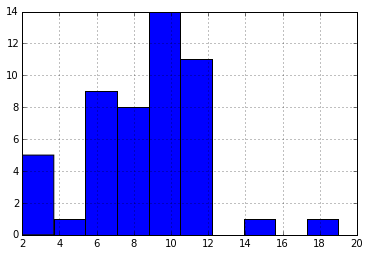

In [29]:
get_distribution (50)

# D)